# Two Birds, One Neural Network Challenge - Starter Notebook


## Background
The original concept for this challenge comes from the difficulties of understanding the Earth using only a limited number of data sources that could be interpreted in a multitude of ways.    McAliley and Li (2021) took an interesting approach to this problem by using generative algorithms to create diverse output models consistent with a series of measurements.   The algorithm produced many potential output solutions that scientists could use to make better predictions or plan future data gathering.

This challenge expands upon the work of McAliley and Li (2021) by asking you to develop a generative neural network that maximizes the diversity of generated outputs consistent with **two** complex conditions.   How many sets of inputs simultaneously satisfy both conditions? How diverse will these sets of solutions be? These are the core questions of the Two Birds, One Neural Network challenge.

## The Statement of the Problem

In this challenge, we have two given conditions, or models, Y0, Y1 captured by these equations:  

$$
y_1 = \cos(49 \cdot x_0 + 42 \cdot x_1)
$$

$$
y_2 = \cos(56 \cdot x_0 + 63 \cdot x_1)
$$

As you can see, the equations are a function of the vectors X0 (decreasing straight line) and X1 (increasing straight line). Can we generate a complete solution space of combination (X0, X1) simultaneously satisfying functions Y0 and Y1? Can we develop a neural network that can generate the most diverse set of solutions satisfying both conditions?

This Challenge asks you to develop a neural network of arbitrary nature at the participant's choice. This could be any variation of an autoencoder (e.g., CVAE), a generative adversarial network (GAN), or any other network that allows you to generate the desired variety of solutions.

Our example is built on a network type, such as a conditional variational autoencoder (CVAE), in which given functions are used as conditionals.

If you prefer to use the proposed CVAE, then **any changes, including hyperparameters, configuration of layers, loss function, optimizer, etc., are welcomed**.

Again, the Challenge aims **to develop a neural network and find the optimal values for hyperparameters and other constraints** to achieve **a complete space of reconstructed X0/X1**. Remember that X0/X1 should preserve the nature of the provided data, including the sign of the slope, closeness to a straight line, and producing the Y0/Y1 almost match to the given Y1/Y2.
             
## Description of provided data   

For training and evaluation of NN we are providing:  
 - **train_dataset.pt** (100,000 elements) - to build your solution.
 - **validation_dataset.pt** (3,000 elements) - to validate your soltuion.

Both dataset have the same structure: 
Each element is tensor structured as a pair of X0/X1 straight lines from 50 points (X0 is descending, X1 is ascending) along as associated tensor of conditional values Y1/Y2 for each pair X0/X1.

For evaluation the **scoring_dataset.pt**  has the same structure but only 50 elements.  This dataset must be used to generate scores on the Predictive Leaderboard as described below.

## Evaluation process

### Predictive Scoring Evaluation

Participants must use the provided scoring dataset and all other materials to generate results. Specifically, all 50 elements from the scoring dataset must be utilized to generate 30 samples for each element. The shape of the resulting dataset will be a threshold scoring criteria, ensuring the presence of all 50 elements.

During the Predictive Scoring calculation, the '"nature of data" will be investigated, which includes the following criteria:
 - X0 should exhibit a descending pattern, and X1 should show an ascending pattern.
 - X0 and X1 should closely resemble straight lines (i.e., Pearson Coefficient) with a goodness of fit greater than 0.8.
 - Reconstructed Y1/Y2, computed as functions on reconstructed X0/X1, should closely match the provided Y1/Y2 values.  The RMSE should be less than 0.1.
 
All the abovementioned requirements are mandatory and will be assessed for the entire result. The score will be set to 0 if these criteria are not met. In all other cases, the score will be calculated as a coverage score within the [0,1] interval.


### Final Scoring Evaluation

The best submissions on the Predictive Leaderboard will be invited to the Final Evaluation process.   Please ensure that your code is runnable, easy to follow, and reproducible. We offer the following recommendations:

 -  Create a notebook with a clear and easily followable pipeline.
 -  Include a reasonable amount of comments and descriptions to help us fully understand the brilliance of your solution.
 - Explicitly set seeds for the training process (code example for this can be found below) to ensure the Judges can reproduce your results; otherwise, your solution may be disqualified.

For the Final Evaluation, 100 X0/X1 samples will be generated on a larger scoring dataset containing 1000 elements. **Please note that the final_scoring_dataset is fixed and will be the same for all provided submissions**.

The Final Assessment will be calculated using the following formula:


$$
\text{FinalAssessment} = 0.3 \cdot \text{LiveScoring} + 0.65 \cdot \text{FinalScoring} + 0.05 \cdot \text{Interpretability}
$$


The interpretability criterion will focus on the extent of documentation, including docstrings and markdown, clear variable naming, and adherence to standard Python style guidelines. 

## Provided functionality

Below, a quick start for this challenge is provided using CVAE. The architecture of the CVAE is provided in a separate file, **CVAE_example.py**, along with a configuration file, **config_model.yaml**. Functions for training, testing, plotting, and sample generation are also provided separately in the **CVAE_function.py** module.
## 0. Environment & settings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset  

import torch.utils.data as data_utils


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yaml


# Module with CVAE antares architecture
import CVAE_example as CVAE 

#Module w/ith all related CVAE functions: train, test, etc.
import CVAE_functions as CVAE_fn


# setup device cuda vs. cpu
cuda = torch.cuda.is_available()

# device = torch.device("mps")
device = torch.device("cuda")

def f_y_0(x0, x1):
    return np.sin(5 * x0 + 3 * x1)


def f_y_1(x0, x1):
    return np.cos(4 * x0 + 8 * x1)

functions = [f_y_0, f_y_1]

In [2]:
device

device(type='cuda')

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:51:05_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0


## 1. Prepare Dataset
### 1.1. Load Dataset

Download datasets: **test_dataset.pt** and **validation_dataset.pt** and put them into the **'/data'** folder. Otherwise, edit the following hardcoded path to your own. 

In [5]:
data_root = 'D:/aiml projects/BH 24-2y/bh2y_final resources/bh2y_final resources/data_1/'  #edit it for you own path to datasets
filename = "_dataset" 

filename_dataset = f'{data_root}train{filename}.pt'
filename_validation_dataset = f'{data_root}validation{filename}.pt'

dataset = CVAE_fn.SignalDataset(torch.load(filename_dataset))
dataset_validation = CVAE_fn.SignalDataset(torch.load(filename_validation_dataset))

print(f"Train dataset is loaded successfully and has length: {len(dataset)}")
print(f"Validation dataset is loaded successfully and has length: {len(dataset_validation)}")

# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = 100, shuffle=True)

# create a PyTorch DataLoader from the dataset_test
validation_loader = DataLoader(dataset_validation, batch_size=100, shuffle=True)

Train dataset is loaded successfully and has length: 100000
Validation dataset is loaded successfully and has length: 3000


### 1.2. Plot Random Samples

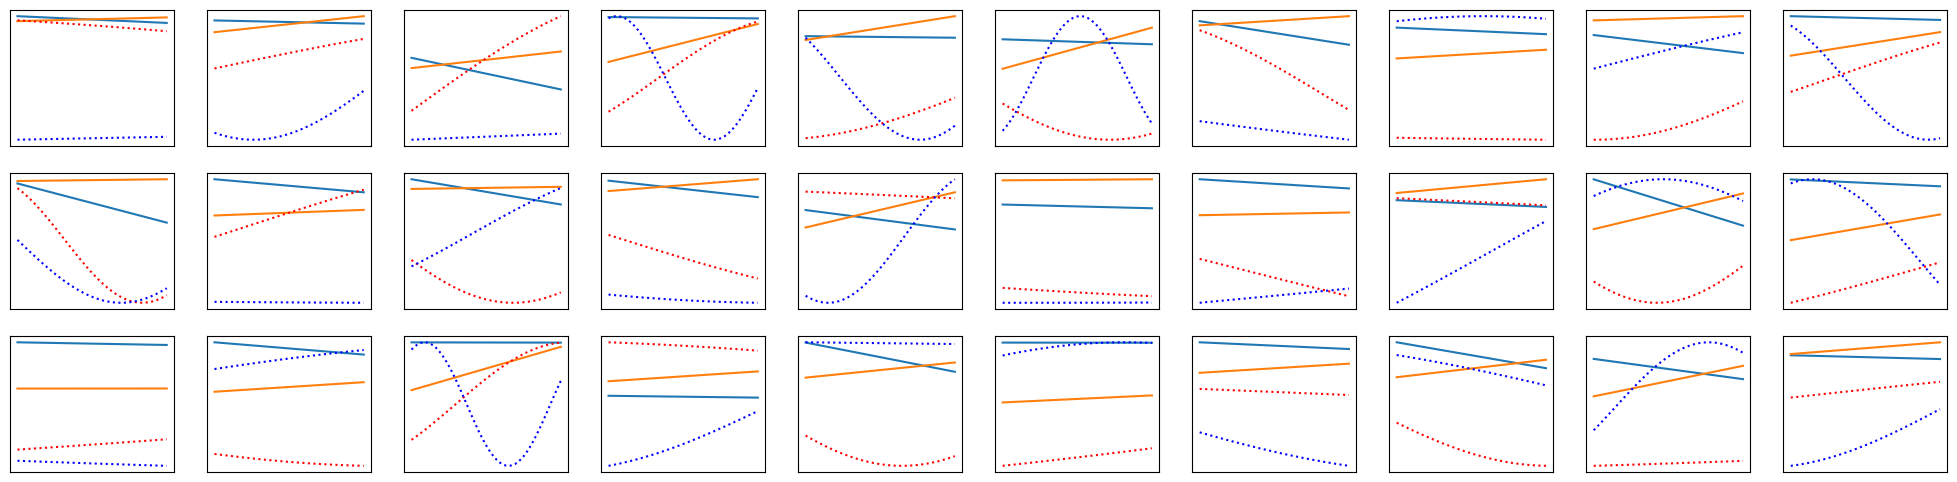

In [6]:
x,y = next(iter(dataloader))        
num_samples = 30

CVAE_fn.plot_samples(x, y, num_samples = num_samples)

## 2. Model setup and train
### 2.1. Define the model and optimizer

Here, we invite you to create your own neural network instead of the provided example or upgrade the suggested CVAE with any other possible changes, including (but not limited to) the loss function, optimizer, and hyperparameters. 

In [7]:
number_of_functions = len(functions)

# Customize your Model’s Architecture Based on next dictionary 
model_parameters = {
    "number_of_points": 50,
    "number_of_inputs": 2,
    "number_of_functions": number_of_functions, 
    "bias": True,
    "in_channels1": 1,
    "out_channels1": 16 ,
    "kernel_size1": [6, 2],
    "out_channels2": 64,
    "kernel_size2": [4, 1],
    "out_channels3": 64,
    "kernel_size3": [4, 1]
}

with open('config_model.yaml', 'w') as f:
    yaml.dump(model_parameters, f)
    
    
# Define the input dimensions
number_of_points = 50
number_of_inputs = model_parameters['number_of_inputs']
number_of_functions = model_parameters['number_of_functions']
input_shape = (1, number_of_points, number_of_inputs)
cond_shape = (number_of_points, number_of_functions)


# Define initial state of hyperparameters
hyperparameters = {
    'latent_dim': 8,
    'lr': 0.004699203904034449,
    'beta': 13.254604785840401,
    'wx': 0.2797739476512935,
    'wy': 0.1487447727368247,
    'batch_size': 232,
    "epoch":50
    }



latent_dim, lr, beta,  wx, wy,batch_size, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

c:\Users\Aerof\.conda\envs\groundingdino\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Current CVAE configuration: 


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(6, 2), stride=(1, 1))
    (conv2): Conv2d(16, 64, kernel_size=(4, 1), stride=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=2688, out_features=8, bias=True)
    (fc1_logvar): Linear(in_features=2688, out_features=8, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=2688, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(4, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 16, kernel_size=(4, 1), stride=(1, 1))
    (conv_transpose3): ConvTranspose2d(16, 1, kernel_size=(6, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

### 2.2. Generate samples from the untrained model

In [8]:
# update PyTorch DataLoader with current value of batch_size
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
num_samples = 30

x_batch, y_batch = next(iter(dataloader))
y_idx = np.random.randint(batch_size)
given_x = x_batch[y_idx].unsqueeze(0).to(device) 
given_y = y_batch[y_idx].unsqueeze(0).to(device) 

given_y = torch.reshape(given_y, (len(given_y), number_of_points* number_of_functions))

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2496 and 2688x8)

### 2.3. Train & validate model

In [11]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
    print(epoch_result)
    
    
CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions)
   

Train Epoch 1: Average Loss: 34.479184, KDL: 2.595570, x_loss: 0.113622, y_loss: 0.296728
{'epoch': 1, 'average_loss': 34.47918372759078, 'KLD_loss': 2.5955704231229095, 'x_loss': 0.11362159895469193, 'y_loss': 0.29672755297549347}
Train Epoch 2: Average Loss: 0.054074, KDL: 0.000176, x_loss: 0.078951, y_loss: 0.199363
{'epoch': 2, 'average_loss': 0.054073751326305444, 'KLD_loss': 0.00017588385553271682, 'x_loss': 0.07895059361881404, 'y_loss': 0.1993627048752926}
Train Epoch 3: Average Loss: 0.066010, KDL: 0.001404, x_loss: 0.072558, y_loss: 0.182222
{'epoch': 3, 'average_loss': 0.06601004013619213, 'KLD_loss': 0.001403708493819943, 'x_loss': 0.07255826741284518, 'y_loss': 0.18222170366250254}
Train Epoch 4: Average Loss: 0.045041, KDL: 0.000040, x_loss: 0.069096, y_loss: 0.169294
{'epoch': 4, 'average_loss': 0.045041065775202935, 'KLD_loss': 3.984073797861735e-05, 'x_loss': 0.06909635537131517, 'y_loss': 0.1692942264834764}
Train Epoch 5: Average Loss: 0.044377, KDL: 0.000040, x_loss

0.03951109647750854

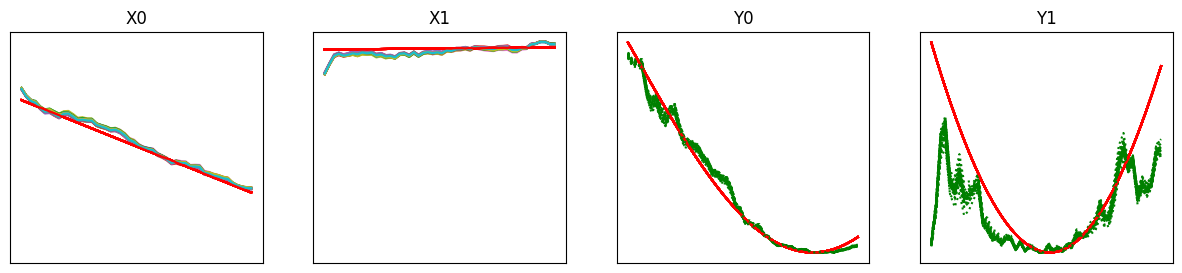

In [12]:
x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points
                                    , number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

### 2.4. Hyperparameter's tuning process 

In [9]:
import optuna


number_of_functions = len(functions)

# Customize your Model’s Architecture Based on next dictionary 
model_parameters = {
    "number_of_points": 50,
    "number_of_inputs": 2,
    "number_of_functions": number_of_functions, 
    "bias": True,
    "in_channels1": 1,
    "out_channels1": 16,
    "kernel_size1": [6, 2],
    "out_channels2": 64,
    "kernel_size2": [4, 1]
}

with open('config_model.yaml', 'w') as f:
    yaml.dump(model_parameters, f)
    
    
# Define the input dimensions
number_of_points = 50
number_of_inputs = model_parameters['number_of_inputs']
number_of_functions = model_parameters['number_of_functions']
input_shape = (1, number_of_points, number_of_inputs)
cond_shape = (number_of_points, number_of_functions)


cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

model

c:\Users\Aerof\.conda\envs\groundingdino\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(6, 2), stride=(1, 1))
    (conv2): Conv2d(16, 64, kernel_size=(4, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=2688, out_features=21, bias=True)
    (fc1_logvar): Linear(in_features=2688, out_features=21, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=2688, bias=True)
    (conv_transpose2): ConvTranspose2d(64, 16, kernel_size=(4, 1), stride=(1, 1))
    (conv_transpose3): ConvTranspose2d(16, 1, kernel_size=(6, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

In [10]:
import optuna

def training_with_optuna( lr, batch_size, beta, wx, wy,num_epochs, latent_dim):

    print("lr =" , lr , ", batch = " , batch_size ,  ", beta= " , beta, ", wx= ", wx , ", wy = ", wy , ", latent_dim = " , latent_dim)
    
    cvae = CVAE.CVAE(latent_dim).to(device)

    model = cvae
    optimizer = optim.Adam(model.parameters(), lr = lr)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

    for epoch in range(1, num_epochs + 1):
        epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
        print(epoch_result)
    
    return(epoch_result["average_loss"])


def objective(trial):
    params = {
    "latent_dim": trial.suggest_int("latent_dim", 3,25),
    "lr" : trial.suggest_float("lr", 1e-4, 0.01),
    "batch_size" : trial.suggest_int("batch_size", 64,256),
    # "batch_size": 128,
    "beta" : trial.suggest_float("beta", 1,15),
    "wx": trial.suggest_float("wx", 0.1, 11),
    "wy": trial.suggest_float("wy",0.1,11),
    "epoch":21
    }

    return training_with_optuna(params["lr"],params["batch_size"] , params["beta"], params["wx"], params["wy"], params["epoch"],params["latent_dim"])


In [11]:
study=optuna.create_study(directions=["minimize"])
study.optimize(objective, n_trials=30)

print("best trial:")
trial_ = study.best_trial

print(trial_.values)
print(trial_.params)

[I 2024-02-16 17:14:09,355] A new study created in memory with name: no-name-124ff9d9-3732-4635-a1df-f91d24275277


lr = 0.005627950203801477 , batch =  186 , beta=  2.252102397929369 , wx=  0.9834878542037578 , wy =  9.932180706284054 , latent_dim =  21
Train Epoch 1: Average Loss: 12.984134, KDL: 4.254289, x_loss: 0.123202, y_loss: 0.330428
{'epoch': 1, 'average_loss': 12.98413381257465, 'KLD_loss': 4.254289137774241, 'x_loss': 0.12320158504586681, 'y_loss': 0.33042815083907884}
Train Epoch 2: Average Loss: 2.196823, KDL: -0.000017, x_loss: 0.081057, y_loss: 0.213160
{'epoch': 2, 'average_loss': 2.1968225683864606, 'KLD_loss': -1.7212281439827278e-05, 'x_loss': 0.08105691255080656, 'y_loss': 0.21315992598639988}
Train Epoch 3: Average Loss: 2.001473, KDL: -0.000016, x_loss: 0.075172, y_loss: 0.194074
{'epoch': 3, 'average_loss': 2.001472500841857, 'KLD_loss': -1.5552269924972137e-05, 'x_loss': 0.07517217078893601, 'y_loss': 0.1940738625519781}
Train Epoch 4: Average Loss: 1.869210, KDL: -0.000018, x_loss: 0.071679, y_loss: 0.181104
{'epoch': 4, 'average_loss': 1.8692100209817568, 'KLD_loss': -1.83

[I 2024-02-16 17:15:47,894] Trial 0 finished with value: 1.4432670680120532 and parameters: {'latent_dim': 21, 'lr': 0.005627950203801477, 'batch_size': 186, 'beta': 2.252102397929369, 'wx': 0.9834878542037578, 'wy': 9.932180706284054}. Best is trial 0 with value: 1.4432670680120532.


Train Epoch 21: Average Loss: 1.443267, KDL: 0.000071, x_loss: 0.058943, y_loss: 0.139460
{'epoch': 21, 'average_loss': 1.4432670680120532, 'KLD_loss': 7.071847366134473e-05, 'x_loss': 0.05894268619859085, 'y_loss': 0.13945964855387752}
lr = 0.009503127404530716 , batch =  158 , beta=  5.234316765714454 , wx=  9.721525062477914 , wy =  6.37032216544795 , latent_dim =  21
Train Epoch 1: Average Loss: 38.407405, KDL: 6.578046, x_loss: 0.176465, y_loss: 0.354820
{'epoch': 1, 'average_loss': 38.407404522948546, 'KLD_loss': 6.578046313629708, 'x_loss': 0.17646488569688645, 'y_loss': 0.3548203296194333}
Train Epoch 2: Average Loss: 2.073604, KDL: 0.000847, x_loss: 0.080014, y_loss: 0.202708
{'epoch': 2, 'average_loss': 2.0736036340207287, 'KLD_loss': 0.000847404602014623, 'x_loss': 0.08001354802252746, 'y_loss': 0.20270785124381008}
Train Epoch 3: Average Loss: 1.931208, KDL: 0.000108, x_loss: 0.075265, y_loss: 0.188208
{'epoch': 3, 'average_loss': 1.9312077879340728, 'KLD_loss': 0.000107957

[I 2024-02-16 17:17:26,069] Trial 1 finished with value: 1.5831172338217543 and parameters: {'latent_dim': 21, 'lr': 0.009503127404530716, 'batch_size': 158, 'beta': 5.234316765714454, 'wx': 9.721525062477914, 'wy': 6.37032216544795}. Best is trial 0 with value: 1.4432670680120532.


Train Epoch 21: Average Loss: 1.583117, KDL: -0.000008, x_loss: 0.062869, y_loss: 0.152580
{'epoch': 21, 'average_loss': 1.5831172338217543, 'KLD_loss': -8.13344455254963e-06, 'x_loss': 0.0628686040451553, 'y_loss': 0.15257958062640486}
lr = 0.0006035738958378587 , batch =  244 , beta=  11.793442295245482 , wx=  2.681686622097929 , wy =  0.9124462261330094 , latent_dim =  25
Train Epoch 1: Average Loss: 9.694283, KDL: 0.761466, x_loss: 0.134683, y_loss: 0.386654
{'epoch': 1, 'average_loss': 9.694283042448323, 'KLD_loss': 0.7614659864728044, 'x_loss': 0.13468274219733914, 'y_loss': 0.38665373368961053}
Train Epoch 2: Average Loss: 0.468811, KDL: 0.000734, x_loss: 0.089697, y_loss: 0.240684
{'epoch': 2, 'average_loss': 0.46881059640791356, 'KLD_loss': 0.0007342138668385948, 'x_loss': 0.08969731936004104, 'y_loss': 0.24068441957962222}
Train Epoch 3: Average Loss: 0.410779, KDL: 0.000383, x_loss: 0.080962, y_loss: 0.207304
{'epoch': 3, 'average_loss': 0.410778970398554, 'KLD_loss': 0.0003

[I 2024-02-16 17:18:35,230] Trial 2 finished with value: 0.28168911196109725 and parameters: {'latent_dim': 25, 'lr': 0.0006035738958378587, 'batch_size': 244, 'beta': 11.793442295245482, 'wx': 2.681686622097929, 'wy': 0.9124462261330094}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 0.281689, KDL: 0.000219, x_loss: 0.057973, y_loss: 0.135506
{'epoch': 21, 'average_loss': 0.28168911196109725, 'KLD_loss': 0.00021888570087711987, 'x_loss': 0.05797301329127172, 'y_loss': 0.13550633461010164}
lr = 0.006976710972689424 , batch =  79 , beta=  9.294472119323528 , wx=  0.9627962108979231 , wy =  2.974915409762516 , latent_dim =  7
Train Epoch 1: Average Loss: 3.544280, KDL: 0.286738, x_loss: 0.100754, y_loss: 0.262931
{'epoch': 1, 'average_loss': 3.544279573982549, 'KLD_loss': 0.28673796212127045, 'x_loss': 0.10075368053952194, 'y_loss': 0.262930695302961}
Train Epoch 2: Average Loss: 0.647574, KDL: -0.000002, x_loss: 0.077541, y_loss: 0.192588
{'epoch': 2, 'average_loss': 0.6475740038623554, 'KLD_loss': -1.6278988942150821e-06, 'x_loss': 0.07754097011169833, 'y_loss': 0.1925879845404512}
Train Epoch 3: Average Loss: 0.604217, KDL: -0.000001, x_loss: 0.073236, y_loss: 0.179406
{'epoch': 3, 'average_loss': 0.6042169829445051, 'KLD_loss': -1.214

[I 2024-02-16 17:21:04,363] Trial 3 finished with value: 0.5150117196648795 and parameters: {'latent_dim': 7, 'lr': 0.006976710972689424, 'batch_size': 79, 'beta': 9.294472119323528, 'wx': 0.9627962108979231, 'wy': 2.974915409762516}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 0.515012, KDL: 0.000017, x_loss: 0.061744, y_loss: 0.153082
{'epoch': 21, 'average_loss': 0.5150117196648795, 'KLD_loss': 1.6996575192817578e-05, 'x_loss': 0.061743723246229204, 'y_loss': 0.15308237234704303}
lr = 0.001794821019443689 , batch =  75 , beta=  7.245434713459931 , wx=  10.900182022691734 , wy =  9.778877850437484 , latent_dim =  9
Train Epoch 1: Average Loss: 4.347868, KDL: 0.084854, x_loss: 0.099470, y_loss: 0.270873
{'epoch': 1, 'average_loss': 4.347868220023308, 'KLD_loss': 0.08485357688999605, 'x_loss': 0.0994695148568997, 'y_loss': 0.27087272443379956}
Train Epoch 2: Average Loss: 2.775525, KDL: 0.000010, x_loss: 0.075669, y_loss: 0.199476
{'epoch': 2, 'average_loss': 2.7755248894219635, 'KLD_loss': 9.736534895031884e-06, 'x_loss': 0.0756689422279373, 'y_loss': 0.199475755554804}
Train Epoch 3: Average Loss: 2.503506, KDL: 0.000006, x_loss: 0.070099, y_loss: 0.177870
{'epoch': 3, 'average_loss': 2.50350600936781, 'KLD_loss': 6.49317540507

[I 2024-02-16 17:23:39,575] Trial 4 finished with value: 1.8997351704151377 and parameters: {'latent_dim': 9, 'lr': 0.001794821019443689, 'batch_size': 75, 'beta': 7.245434713459931, 'wx': 10.900182022691734, 'wy': 9.778877850437484}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 1.899735, KDL: 0.000004, x_loss: 0.055994, y_loss: 0.131851
{'epoch': 21, 'average_loss': 1.8997351704151377, 'KLD_loss': 4.179362414301425e-06, 'x_loss': 0.05599425304708988, 'y_loss': 0.13185125359821356}
lr = 0.0057153561823925295 , batch =  195 , beta=  11.143278689761024 , wx=  8.465879583330482 , wy =  7.755994245004194 , latent_dim =  24
Train Epoch 1: Average Loss: 53.240068, KDL: 4.502075, x_loss: 0.108107, y_loss: 0.278104
{'epoch': 1, 'average_loss': 53.2400683580551, 'KLD_loss': 4.502075020507065, 'x_loss': 0.10810688364575481, 'y_loss': 0.27810364804769816}
Train Epoch 2: Average Loss: 2.247982, KDL: 0.000297, x_loss: 0.080186, y_loss: 0.201886
{'epoch': 2, 'average_loss': 2.247981885488038, 'KLD_loss': 0.0002970637401409781, 'x_loss': 0.0801856120282214, 'y_loss': 0.2018864154234732}
Train Epoch 3: Average Loss: 2.061517, KDL: 0.000196, x_loss: 0.074525, y_loss: 0.184168
{'epoch': 3, 'average_loss': 2.061517151940403, 'KLD_loss': 0.0001961928

[I 2024-02-16 17:24:58,922] Trial 5 finished with value: 1.9285078155599376 and parameters: {'latent_dim': 24, 'lr': 0.0057153561823925295, 'batch_size': 195, 'beta': 11.143278689761024, 'wx': 8.465879583330482, 'wy': 7.755994245004194}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 1.928508, KDL: 0.000083, x_loss: 0.070295, y_loss: 0.171800
{'epoch': 21, 'average_loss': 1.9285078155599376, 'KLD_loss': 8.26442218431023e-05, 'x_loss': 0.07029484860874989, 'y_loss': 0.17179991604059527}
lr = 0.008737232124792578 , batch =  220 , beta=  12.727223490015403 , wx=  5.7297497637160815 , wy =  3.026909334346587 , latent_dim =  11
Train Epoch 1: Average Loss: 167.222525, KDL: 12.989298, x_loss: 0.155381, y_loss: 0.335169
{'epoch': 1, 'average_loss': 167.22252539998883, 'KLD_loss': 12.989297673531942, 'x_loss': 0.1553813357110862, 'y_loss': 0.3351689930473055}
Train Epoch 2: Average Loss: 1.105796, KDL: 0.006170, x_loss: 0.077934, y_loss: 0.191856
{'epoch': 2, 'average_loss': 1.1057961293629237, 'KLD_loss': 0.00616983908873338, 'x_loss': 0.07793369118001435, 'y_loss': 0.1918559811599962}
Train Epoch 3: Average Loss: 1.420789, KDL: 0.034707, x_loss: 0.074025, y_loss: 0.183330
{'epoch': 3, 'average_loss': 1.420789128607446, 'KLD_loss': 0.03470670

[I 2024-02-16 17:26:11,590] Trial 6 finished with value: 0.8010488574321454 and parameters: {'latent_dim': 11, 'lr': 0.008737232124792578, 'batch_size': 220, 'beta': 12.727223490015403, 'wx': 5.7297497637160815, 'wy': 3.026909334346587}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 0.801049, KDL: 0.000000, x_loss: 0.062128, y_loss: 0.147037
{'epoch': 21, 'average_loss': 0.8010488574321454, 'KLD_loss': 9.287844647418012e-08, 'x_loss': 0.06212849429511762, 'y_loss': 0.14703676366544033}
lr = 0.008405832889475481 , batch =  159 , beta=  4.9793029695420765 , wx=  9.709499507372238 , wy =  10.920982419612203 , latent_dim =  5
Train Epoch 1: Average Loss: 17.560784, KDL: 2.440536, x_loss: 0.154519, y_loss: 0.357873
{'epoch': 1, 'average_loss': 17.560784422915386, 'KLD_loss': 2.4405355178684425, 'x_loss': 0.1545187139880676, 'y_loss': 0.357872505137765}
Train Epoch 2: Average Loss: 2.902763, KDL: 0.000155, x_loss: 0.077470, y_loss: 0.196850
{'epoch': 2, 'average_loss': 2.9027625585777392, 'KLD_loss': 0.00015457787081622925, 'x_loss': 0.07747002201827038, 'y_loss': 0.1968502157111615}
Train Epoch 3: Average Loss: 2.711751, KDL: 0.000086, x_loss: 0.073130, y_loss: 0.183250
{'epoch': 3, 'average_loss': 2.7117512029001936, 'KLD_loss': 8.6298949

[I 2024-02-16 17:27:42,635] Trial 7 finished with value: 2.353407254658746 and parameters: {'latent_dim': 5, 'lr': 0.008405832889475481, 'batch_size': 159, 'beta': 4.9793029695420765, 'wx': 9.709499507372238, 'wy': 10.920982419612203}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 2.353407, KDL: 0.000033, x_loss: 0.065338, y_loss: 0.157389
{'epoch': 21, 'average_loss': 2.353407254658746, 'KLD_loss': 3.3451803916967544e-05, 'x_loss': 0.06533811645899175, 'y_loss': 0.1573887982883969}
lr = 0.004046866262921888 , batch =  114 , beta=  3.3110216432036994 , wx=  9.89457827920337 , wy =  10.173004018583617 , latent_dim =  20
Train Epoch 1: Average Loss: 6.126087, KDL: 0.641609, x_loss: 0.104919, y_loss: 0.291318
{'epoch': 1, 'average_loss': 6.126086814256898, 'KLD_loss': 0.6416089300549926, 'x_loss': 0.10491888625610933, 'y_loss': 0.2913178407453459}
Train Epoch 2: Average Loss: 2.883209, KDL: 0.000009, x_loss: 0.079044, y_loss: 0.206534
{'epoch': 2, 'average_loss': 2.8832091609003334, 'KLD_loss': 9.443806081263513e-06, 'x_loss': 0.07904376586844003, 'y_loss': 0.20653419196605682}
Train Epoch 3: Average Loss: 2.639990, KDL: 0.000008, x_loss: 0.073622, y_loss: 0.187900
{'epoch': 3, 'average_loss': 2.6399901905744114, 'KLD_loss': 8.30636209

[I 2024-02-16 17:29:34,275] Trial 8 finished with value: 2.011072776040618 and parameters: {'latent_dim': 20, 'lr': 0.004046866262921888, 'batch_size': 114, 'beta': 3.3110216432036994, 'wx': 9.89457827920337, 'wy': 10.173004018583617}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 2.011073, KDL: 0.000028, x_loss: 0.058596, y_loss: 0.140686
{'epoch': 21, 'average_loss': 2.011072776040618, 'KLD_loss': 2.823583357426463e-05, 'x_loss': 0.05859606457632332, 'y_loss': 0.14068567521174297}
lr = 0.0043689150846577575 , batch =  210 , beta=  4.981780154343142 , wx=  5.878138841444699 , wy =  0.5714760908359869 , latent_dim =  11
Train Epoch 1: Average Loss: 12.147395, KDL: 2.260439, x_loss: 0.119445, y_loss: 0.322442
{'epoch': 1, 'average_loss': 12.147395223066741, 'KLD_loss': 2.2604391204361147, 'x_loss': 0.11944543660874136, 'y_loss': 0.3224416736911678}
Train Epoch 2: Average Loss: 0.594267, KDL: 0.000347, x_loss: 0.079911, y_loss: 0.214896
{'epoch': 2, 'average_loss': 0.5942668681749508, 'KLD_loss': 0.0003471880588891371, 'x_loss': 0.07991120654238346, 'y_loss': 0.21489625194537565}
Train Epoch 3: Average Loss: 0.551286, KDL: 0.000397, x_loss: 0.074395, y_loss: 0.195989
{'epoch': 3, 'average_loss': 0.5512861414525494, 'KLD_loss': 0.00039

[I 2024-02-16 17:30:49,247] Trial 9 finished with value: 0.4170819394118631 and parameters: {'latent_dim': 11, 'lr': 0.0043689150846577575, 'batch_size': 210, 'beta': 4.981780154343142, 'wx': 5.878138841444699, 'wy': 0.5714760908359869}. Best is trial 2 with value: 0.28168911196109725.


Train Epoch 21: Average Loss: 0.417082, KDL: 0.000007, x_loss: 0.057727, y_loss: 0.135998
{'epoch': 21, 'average_loss': 0.4170819394118631, 'KLD_loss': 7.1767366157387785e-06, 'x_loss': 0.05772687268269637, 'y_loss': 0.13599799493761183}
lr = 0.00033944234000734337 , batch =  252 , beta=  14.968291041859176 , wx=  3.2629625364519126 , wy =  0.5914525985305907 , latent_dim =  15
Train Epoch 1: Average Loss: 3.201506, KDL: 0.159576, x_loss: 0.167896, y_loss: 0.448203
{'epoch': 1, 'average_loss': 3.2015056281305982, 'KLD_loss': 0.1595756777888281, 'x_loss': 0.1678964272704473, 'y_loss': 0.44820267187257856}
Train Epoch 2: Average Loss: 0.495994, KDL: 0.001465, x_loss: 0.096838, y_loss: 0.267295
{'epoch': 2, 'average_loss': 0.49599385509262756, 'KLD_loss': 0.0014646328066098, 'x_loss': 0.09683796526953316, 'y_loss': 0.26729470562724683}
Train Epoch 3: Average Loss: 0.415015, KDL: 0.000621, x_loss: 0.084437, y_loss: 0.220147
{'epoch': 3, 'average_loss': 0.41501523317858313, 'KLD_loss': 0.00

[I 2024-02-16 17:31:56,233] Trial 10 finished with value: 0.2669512354757083 and parameters: {'latent_dim': 15, 'lr': 0.00033944234000734337, 'batch_size': 252, 'beta': 14.968291041859176, 'wx': 3.2629625364519126, 'wy': 0.5914525985305907}. Best is trial 10 with value: 0.2669512354757083.


Train Epoch 21: Average Loss: 0.266951, KDL: 0.000134, x_loss: 0.057611, y_loss: 0.130112
{'epoch': 21, 'average_loss': 0.2669512354757083, 'KLD_loss': 0.00013443594915740737, 'x_loss': 0.05761144458496901, 'y_loss': 0.1301118154782492}
lr = 0.00033551959169901254 , batch =  253 , beta=  14.958052616313271 , wx=  2.8558662883613564 , wy =  0.43235276900693126 , latent_dim =  16
Train Epoch 1: Average Loss: 5.448683, KDL: 0.320519, x_loss: 0.162184, y_loss: 0.442163
{'epoch': 1, 'average_loss': 5.448682989511225, 'KLD_loss': 0.3205188435285982, 'x_loss': 0.16218366669585008, 'y_loss': 0.44216300080520937}
Train Epoch 2: Average Loss: 0.414384, KDL: 0.001834, x_loss: 0.095725, y_loss: 0.262696
{'epoch': 2, 'average_loss': 0.4143840739070767, 'KLD_loss': 0.0018337294459342957, 'x_loss': 0.09572501405320986, 'y_loss': 0.2626957113318371}
Train Epoch 3: Average Loss: 0.347761, KDL: 0.000903, x_loss: 0.084250, y_loss: 0.216603
{'epoch': 3, 'average_loss': 0.3477609661040884, 'KLD_loss': 0.00

[I 2024-02-16 17:33:02,982] Trial 11 finished with value: 0.22592851252417373 and parameters: {'latent_dim': 16, 'lr': 0.00033551959169901254, 'batch_size': 253, 'beta': 14.958052616313271, 'wx': 2.8558662883613564, 'wy': 0.43235276900693126}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.225929, KDL: 0.000174, x_loss: 0.058024, y_loss: 0.133267
{'epoch': 21, 'average_loss': 0.22592851252417373, 'KLD_loss': 0.00017400033245183, 'x_loss': 0.05802356579689064, 'y_loss': 0.13326678720462803}
lr = 0.0002415277836181318 , batch =  244 , beta=  14.958305490335654 , wx=  3.788655770043297 , wy =  2.878878891138646 , latent_dim =  16
Train Epoch 1: Average Loss: 6.164275, KDL: 0.280863, x_loss: 0.165674, y_loss: 0.463849
{'epoch': 1, 'average_loss': 6.164275339463862, 'KLD_loss': 0.2808626452597176, 'x_loss': 0.16567356064915656, 'y_loss': 0.46384931737329904}
Train Epoch 2: Average Loss: 1.237318, KDL: 0.002334, x_loss: 0.099644, y_loss: 0.286531
{'epoch': 2, 'average_loss': 1.2373179342688583, 'KLD_loss': 0.002334096809712852, 'x_loss': 0.0996440928520226, 'y_loss': 0.28653051522446843}
Train Epoch 3: Average Loss: 1.032140, KDL: 0.001253, x_loss: 0.088318, y_loss: 0.235784
{'epoch': 3, 'average_loss': 1.0321404771107, 'KLD_loss': 0.00125287058

[I 2024-02-16 17:34:10,670] Trial 12 finished with value: 0.614680443304341 and parameters: {'latent_dim': 16, 'lr': 0.0002415277836181318, 'batch_size': 244, 'beta': 14.958305490335654, 'wx': 3.788655770043297, 'wy': 2.878878891138646}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.614680, KDL: 0.000343, x_loss: 0.058789, y_loss: 0.134364
{'epoch': 21, 'average_loss': 0.614680443304341, 'KLD_loss': 0.0003430610022893766, 'x_loss': 0.05878880539136689, 'y_loss': 0.1343642120681158}
lr = 0.002657784022000916 , batch =  253 , beta=  14.427848638155329 , wx=  3.587038886396434 , wy =  0.27561151514085425 , latent_dim =  15
Train Epoch 1: Average Loss: 52.149300, KDL: 3.578365, x_loss: 0.120880, y_loss: 0.317767
{'epoch': 1, 'average_loss': 52.149299717837515, 'KLD_loss': 3.5783654110449734, 'x_loss': 0.12088022810040099, 'y_loss': 0.3177671357989311}
Train Epoch 2: Average Loss: 0.349230, KDL: 0.000276, x_loss: 0.080027, y_loss: 0.211144
{'epoch': 2, 'average_loss': 0.34922990880229254, 'KLD_loss': 0.0002757067782710297, 'x_loss': 0.08002655058534759, 'y_loss': 0.21114391867410054}
Train Epoch 3: Average Loss: 0.317185, KDL: 0.000075, x_loss: 0.073635, y_loss: 0.188585
{'epoch': 3, 'average_loss': 0.31718516861549534, 'KLD_loss': 7.478

[I 2024-02-16 17:35:18,217] Trial 13 finished with value: 0.24372379086685902 and parameters: {'latent_dim': 15, 'lr': 0.002657784022000916, 'batch_size': 253, 'beta': 14.427848638155329, 'wx': 3.587038886396434, 'wy': 0.27561151514085425}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.243724, KDL: 0.000002, x_loss: 0.057403, y_loss: 0.137096
{'epoch': 21, 'average_loss': 0.24372379086685902, 'KLD_loss': 2.19754498414319e-06, 'x_loss': 0.057403030645365664, 'y_loss': 0.13709577763772973}
lr = 0.002645232324370419 , batch =  223 , beta=  13.244770320453576 , wx=  4.688478287625968 , wy =  4.249829348230771 , latent_dim =  16
Train Epoch 1: Average Loss: 35.051757, KDL: 2.521938, x_loss: 0.102555, y_loss: 0.274939
{'epoch': 1, 'average_loss': 35.05175658934366, 'KLD_loss': 2.521938091795269, 'x_loss': 0.1025546222161875, 'y_loss': 0.2749385860953936}
Train Epoch 2: Average Loss: 1.210264, KDL: 0.000006, x_loss: 0.078439, y_loss: 0.198226
{'epoch': 2, 'average_loss': 1.2102639780012696, 'KLD_loss': 5.775743178641611e-06, 'x_loss': 0.07843918232185007, 'y_loss': 0.1982260943786604}
Train Epoch 3: Average Loss: 1.104298, KDL: -0.000007, x_loss: 0.072573, y_loss: 0.179804
{'epoch': 3, 'average_loss': 1.104298436163794, 'KLD_loss': -7.3548016

[I 2024-02-16 17:36:30,586] Trial 14 finished with value: 0.8418285125878978 and parameters: {'latent_dim': 16, 'lr': 0.002645232324370419, 'batch_size': 223, 'beta': 13.244770320453576, 'wx': 4.688478287625968, 'wy': 4.249829348230771}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.841829, KDL: -0.000000, x_loss: 0.057276, y_loss: 0.134899
{'epoch': 21, 'average_loss': 0.8418285125878978, 'KLD_loss': -4.0322741315200226e-07, 'x_loss': 0.057275846998781826, 'y_loss': 0.13489889527747784}
lr = 0.0025634591215008056 , batch =  131 , beta=  9.659474086105806 , wx=  2.0346445396286326 , wy =  2.0090104776642512 , latent_dim =  18
Train Epoch 1: Average Loss: 7.567127, KDL: 0.709194, x_loss: 0.098074, y_loss: 0.257411
{'epoch': 1, 'average_loss': 7.567127042064804, 'KLD_loss': 0.7091939120470542, 'x_loss': 0.09807391758735111, 'y_loss': 0.2574107833986819}
Train Epoch 2: Average Loss: 0.539431, KDL: 0.000002, x_loss: 0.076597, y_loss: 0.190922
{'epoch': 2, 'average_loss': 0.5394307953056865, 'KLD_loss': 2.0464131345299525e-06, 'x_loss': 0.07659701488580535, 'y_loss': 0.1909215082243787}
Train Epoch 3: Average Loss: 0.495236, KDL: -0.000000, x_loss: 0.071415, y_loss: 0.174183
{'epoch': 3, 'average_loss': 0.4952364453938619, 'KLD_loss': -3

[I 2024-02-16 17:38:12,543] Trial 15 finished with value: 0.382071665561324 and parameters: {'latent_dim': 18, 'lr': 0.0025634591215008056, 'batch_size': 131, 'beta': 9.659474086105806, 'wx': 2.0346445396286326, 'wy': 2.0090104776642512}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.382072, KDL: 0.000016, x_loss: 0.056920, y_loss: 0.132454
{'epoch': 21, 'average_loss': 0.382071665561324, 'KLD_loss': 1.63215695251345e-05, 'x_loss': 0.05691981423860757, 'y_loss': 0.1324544638902417}
lr = 0.0015893874615782065 , batch =  182 , beta=  13.910856875045848 , wx=  6.892168797935355 , wy =  5.006821962022413 , latent_dim =  13
Train Epoch 1: Average Loss: 10.307602, KDL: 0.581471, x_loss: 0.105783, y_loss: 0.297547
{'epoch': 1, 'average_loss': 10.3076021027565, 'KLD_loss': 0.5814709529009733, 'x_loss': 0.10578342626040632, 'y_loss': 0.2975471164692532}
Train Epoch 2: Average Loss: 1.569034, KDL: 0.000028, x_loss: 0.078756, y_loss: 0.204890
{'epoch': 2, 'average_loss': 1.5690341799909417, 'KLD_loss': 2.7691559358076614e-05, 'x_loss': 0.07875637250190431, 'y_loss': 0.20488979168913582}
Train Epoch 3: Average Loss: 1.418493, KDL: 0.000029, x_loss: 0.072207, y_loss: 0.183834
{'epoch': 3, 'average_loss': 1.4184930634498596, 'KLD_loss': 2.93350761

[I 2024-02-16 17:39:32,501] Trial 16 finished with value: 1.071558415781368 and parameters: {'latent_dim': 13, 'lr': 0.0015893874615782065, 'batch_size': 182, 'beta': 13.910856875045848, 'wx': 6.892168797935355, 'wy': 5.006821962022413}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 1.071558, KDL: 0.000008, x_loss: 0.056936, y_loss: 0.135621
{'epoch': 21, 'average_loss': 1.071558415781368, 'KLD_loss': 8.160905404524369e-06, 'x_loss': 0.05693640142679215, 'y_loss': 0.1356208735568957}
lr = 0.003388229339370277 , batch =  231 , beta=  10.32864629190926 , wx=  4.282072597504577 , wy =  2.0158206456882635 , latent_dim =  13
Train Epoch 1: Average Loss: 34.314783, KDL: 3.228539, x_loss: 0.100789, y_loss: 0.266271
{'epoch': 1, 'average_loss': 34.31478265333946, 'KLD_loss': 3.22853915672104, 'x_loss': 0.1007892945243635, 'y_loss': 0.2662709650280294}
Train Epoch 2: Average Loss: 0.725953, KDL: 0.000213, x_loss: 0.077416, y_loss: 0.194589
{'epoch': 2, 'average_loss': 0.7259532507792906, 'KLD_loss': 0.00021253474590134124, 'x_loss': 0.07741608151490639, 'y_loss': 0.19458911679771151}
Train Epoch 3: Average Loss: 0.662755, KDL: 0.000211, x_loss: 0.071545, y_loss: 0.175719
{'epoch': 3, 'average_loss': 0.6627545191564406, 'KLD_loss': 0.0002105149

[I 2024-02-16 17:40:42,767] Trial 17 finished with value: 0.5089448086796953 and parameters: {'latent_dim': 13, 'lr': 0.003388229339370277, 'batch_size': 231, 'beta': 10.32864629190926, 'wx': 4.282072597504577, 'wy': 2.0158206456882635}. Best is trial 11 with value: 0.22592851252417373.


Train Epoch 21: Average Loss: 0.508945, KDL: 0.000008, x_loss: 0.056655, y_loss: 0.132084
{'epoch': 21, 'average_loss': 0.5089448086796953, 'KLD_loss': 8.264741501136409e-06, 'x_loss': 0.05665520147590384, 'y_loss': 0.1320840476670111}
lr = 0.0015707040892593593 , batch =  255 , beta=  7.136881203790768 , wx=  2.1882141557301935 , wy =  0.1857324674748274 , latent_dim =  3
Train Epoch 1: Average Loss: 0.646120, KDL: 0.052800, x_loss: 0.100148, y_loss: 0.269976
{'epoch': 1, 'average_loss': 0.6461196584631772, 'KLD_loss': 0.052800417477241304, 'x_loss': 0.1001483138754926, 'y_loss': 0.2699764662495703}
Train Epoch 2: Average Loss: 0.202869, KDL: 0.000097, x_loss: 0.076019, y_loss: 0.192897
{'epoch': 2, 'average_loss': 0.2028689880786658, 'KLD_loss': 9.73770788304375e-05, 'x_loss': 0.07601943984627724, 'y_loss': 0.19289686923263638}
Train Epoch 3: Average Loss: 0.188103, KDL: 0.000024, x_loss: 0.070939, y_loss: 0.176064
{'epoch': 3, 'average_loss': 0.18810327229760682, 'KLD_loss': 2.41672

[I 2024-02-16 17:41:49,664] Trial 18 finished with value: 0.14774671014938645 and parameters: {'latent_dim': 3, 'lr': 0.0015707040892593593, 'batch_size': 255, 'beta': 7.136881203790768, 'wx': 2.1882141557301935, 'wy': 0.1857324674748274}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.147747, KDL: -0.000001, x_loss: 0.056435, y_loss: 0.130624
{'epoch': 21, 'average_loss': 0.14774671014938645, 'KLD_loss': -8.538782444922372e-07, 'x_loss': 0.05643495619676192, 'y_loss': 0.13062358131921323}
lr = 0.0013287161173726207 , batch =  203 , beta=  7.660552867150009 , wx=  2.05750881730598 , wy =  6.318498991877459 , latent_dim =  3
Train Epoch 1: Average Loss: 2.472325, KDL: 0.078034, x_loss: 0.097241, y_loss: 0.265010
{'epoch': 1, 'average_loss': 2.472324644092614, 'KLD_loss': 0.0780342875943948, 'x_loss': 0.09724118335372778, 'y_loss': 0.2650098132071582}
Train Epoch 2: Average Loss: 1.353583, KDL: 0.000155, x_loss: 0.074925, y_loss: 0.189639
{'epoch': 2, 'average_loss': 1.3535829620477393, 'KLD_loss': 0.00015523824198492643, 'x_loss': 0.07492514475273312, 'y_loss': 0.189639121445149}
Train Epoch 3: Average Loss: 1.253125, KDL: 0.000083, x_loss: 0.070133, y_loss: 0.175388
{'epoch': 3, 'average_loss': 1.2531254993974559, 'KLD_loss': 8.2912660

[I 2024-02-16 17:43:07,936] Trial 19 finished with value: 0.9434443336229538 and parameters: {'latent_dim': 3, 'lr': 0.0013287161173726207, 'batch_size': 203, 'beta': 7.660552867150009, 'wx': 2.05750881730598, 'wy': 6.318498991877459}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.943444, KDL: 0.000004, x_loss: 0.056372, y_loss: 0.130953
{'epoch': 21, 'average_loss': 0.9434443336229538, 'KLD_loss': 4.249762811718799e-06, 'x_loss': 0.05637209207333367, 'y_loss': 0.13095288886924786}
lr = 0.00118014937390771 , batch =  175 , beta=  6.352517910060852 , wx=  0.5094506549200171 , wy =  1.864582133216902 , latent_dim =  3
Train Epoch 1: Average Loss: 1.460306, KDL: 0.147414, x_loss: 0.095152, y_loss: 0.254953
{'epoch': 1, 'average_loss': 1.460306264407985, 'KLD_loss': 0.14741412492898795, 'x_loss': 0.09515174779181297, 'y_loss': 0.2549526875096184}
Train Epoch 2: Average Loss: 0.389348, KDL: 0.000039, x_loss: 0.075060, y_loss: 0.188171
{'epoch': 2, 'average_loss': 0.38934793463953726, 'KLD_loss': 3.890422257510099e-05, 'x_loss': 0.07506043351274895, 'y_loss': 0.18817148954197244}
Train Epoch 3: Average Loss: 0.357183, KDL: 0.000021, x_loss: 0.070290, y_loss: 0.172286
{'epoch': 3, 'average_loss': 0.35718304507590676, 'KLD_loss': 2.080488

[I 2024-02-16 17:44:40,832] Trial 20 finished with value: 0.27106853056099867 and parameters: {'latent_dim': 3, 'lr': 0.00118014937390771, 'batch_size': 175, 'beta': 6.352517910060852, 'wx': 0.5094506549200171, 'wy': 1.864582133216902}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.271069, KDL: 0.000003, x_loss: 0.056069, y_loss: 0.130048
{'epoch': 21, 'average_loss': 0.27106853056099867, 'KLD_loss': 3.0039386315779253e-06, 'x_loss': 0.05606906736022109, 'y_loss': 0.1300479139663748}
lr = 0.0026361779019926203 , batch =  256 , beta=  12.07857316731237 , wx=  2.1139091945380795 , wy =  0.24031262366418943 , latent_dim =  18
Train Epoch 1: Average Loss: 35.730262, KDL: 2.933316, x_loss: 0.108210, y_loss: 0.296465
{'epoch': 1, 'average_loss': 35.730262332750705, 'KLD_loss': 2.9333161225404276, 'x_loss': 0.10820954192020095, 'y_loss': 0.29646516288332925}
Train Epoch 2: Average Loss: 0.222695, KDL: 0.000227, x_loss: 0.080394, y_loss: 0.208098
{'epoch': 2, 'average_loss': 0.2226950682490073, 'KLD_loss': 0.00022697616416170164, 'x_loss': 0.08039367157975426, 'y_loss': 0.20809807443557798}
Train Epoch 3: Average Loss: 0.204682, KDL: 0.000133, x_loss: 0.074381, y_loss: 0.190760
{'epoch': 3, 'average_loss': 0.20468191874911412, 'KLD_loss': 

[I 2024-02-16 17:45:49,675] Trial 21 finished with value: 0.15497688709012689 and parameters: {'latent_dim': 18, 'lr': 0.0026361779019926203, 'batch_size': 256, 'beta': 12.07857316731237, 'wx': 2.1139091945380795, 'wy': 0.24031262366418943}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.154977, KDL: 0.000014, x_loss: 0.057655, y_loss: 0.137042
{'epoch': 21, 'average_loss': 0.15497688709012689, 'KLD_loss': 1.3796493525395308e-05, 'x_loss': 0.05765493852479379, 'y_loss': 0.13704206556310433}
lr = 0.0020863991550267007 , batch =  236 , beta=  8.79162687983089 , wx=  2.144883877298396 , wy =  1.4227409043923471 , latent_dim =  18
Train Epoch 1: Average Loss: 7.456374, KDL: 0.777911, x_loss: 0.103040, y_loss: 0.278523
{'epoch': 1, 'average_loss': 7.456374149699256, 'KLD_loss': 0.7779105838458493, 'x_loss': 0.10304017658433262, 'y_loss': 0.27852262243769077}
Train Epoch 2: Average Loss: 0.444283, KDL: 0.000036, x_loss: 0.078254, y_loss: 0.194075
{'epoch': 2, 'average_loss': 0.4442827092870226, 'KLD_loss': 3.623252488532156e-05, 'x_loss': 0.07825419068652785, 'y_loss': 0.19407469659762563}
Train Epoch 3: Average Loss: 0.414024, KDL: 0.000037, x_loss: 0.073055, y_loss: 0.180643
{'epoch': 3, 'average_loss': 0.4140244834827927, 'KLD_loss': 3.6531

[I 2024-02-16 17:46:59,861] Trial 22 finished with value: 0.3102857147888193 and parameters: {'latent_dim': 18, 'lr': 0.0020863991550267007, 'batch_size': 236, 'beta': 8.79162687983089, 'wx': 2.144883877298396, 'wy': 1.4227409043923471}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.310286, KDL: 0.000014, x_loss: 0.056921, y_loss: 0.132190
{'epoch': 21, 'average_loss': 0.3102857147888193, 'KLD_loss': 1.4275874731675634e-05, 'x_loss': 0.056920911519313756, 'y_loss': 0.13218953383137594}
lr = 0.0033014663858987455 , batch =  255 , beta=  12.129232361220323 , wx=  1.3028330573360694 , wy =  3.81249620788264 , latent_dim =  18
Train Epoch 1: Average Loss: 57.040875, KDL: 4.596544, x_loss: 0.109377, y_loss: 0.300545
{'epoch': 1, 'average_loss': 57.04087499019147, 'KLD_loss': 4.596543723541968, 'x_loss': 0.10937726550733164, 'y_loss': 0.3005453033074168}
Train Epoch 2: Average Loss: 0.897533, KDL: 0.000022, x_loss: 0.080354, y_loss: 0.207890
{'epoch': 2, 'average_loss': 0.8975331939510414, 'KLD_loss': 2.177283357421254e-05, 'x_loss': 0.08035370282847766, 'y_loss': 0.20789047552429082}
Train Epoch 3: Average Loss: 0.817125, KDL: 0.000040, x_loss: 0.074140, y_loss: 0.188866
{'epoch': 3, 'average_loss': 0.8171246092738086, 'KLD_loss': 3.9779

[I 2024-02-16 17:48:08,143] Trial 23 finished with value: 0.5970479967333282 and parameters: {'latent_dim': 18, 'lr': 0.0033014663858987455, 'batch_size': 255, 'beta': 12.129232361220323, 'wx': 1.3028330573360694, 'wy': 3.81249620788264}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.597048, KDL: 0.000003, x_loss: 0.058295, y_loss: 0.136672
{'epoch': 21, 'average_loss': 0.5970479967333282, 'KLD_loss': 3.1945359615879205e-06, 'x_loss': 0.0582946414180081, 'y_loss': 0.13667189089093196}
lr = 0.0010227701689449298 , batch =  216 , beta=  13.405094916486465 , wx=  2.598684541078731 , wy =  0.18593204699826318 , latent_dim =  11
Train Epoch 1: Average Loss: 7.406568, KDL: 0.527732, x_loss: 0.106591, y_loss: 0.297265
{'epoch': 1, 'average_loss': 7.406567843345277, 'KLD_loss': 0.5277321359251281, 'x_loss': 0.10659136201534622, 'y_loss': 0.2972647190802041}
Train Epoch 2: Average Loss: 0.256823, KDL: 0.000946, x_loss: 0.079519, y_loss: 0.201631
{'epoch': 2, 'average_loss': 0.25682341531079994, 'KLD_loss': 0.0009464982647617744, 'x_loss': 0.07951941269552476, 'y_loss': 0.20163091431426178}
Train Epoch 3: Average Loss: 0.228820, KDL: 0.000454, x_loss: 0.072802, y_loss: 0.180425
{'epoch': 3, 'average_loss': 0.22881969893210394, 'KLD_loss': 0.00

[I 2024-02-16 17:49:21,974] Trial 24 finished with value: 0.17234865773960015 and parameters: {'latent_dim': 11, 'lr': 0.0010227701689449298, 'batch_size': 216, 'beta': 13.405094916486465, 'wx': 2.598684541078731, 'wy': 0.18593204699826318}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.172349, KDL: 0.000024, x_loss: 0.056746, y_loss: 0.132092
{'epoch': 21, 'average_loss': 0.17234865773960015, 'KLD_loss': 2.413659837281987e-05, 'x_loss': 0.05674600987403491, 'y_loss': 0.1320919476240294}
lr = 0.0033503453452992465 , batch =  217 , beta=  10.890167133789667 , wx=  4.7420234122294485 , wy =  1.403621919088121 , latent_dim =  7
Train Epoch 1: Average Loss: 12.549905, KDL: 1.071696, x_loss: 0.103620, y_loss: 0.276137
{'epoch': 1, 'average_loss': 12.549905120938563, 'KLD_loss': 1.0716956668329343, 'x_loss': 0.10362009219259606, 'y_loss': 0.2761369308460819}
Train Epoch 2: Average Loss: 0.635900, KDL: 0.000185, x_loss: 0.076211, y_loss: 0.194131
{'epoch': 2, 'average_loss': 0.6358997771383108, 'KLD_loss': 0.00018524800360590672, 'x_loss': 0.07621141842317944, 'y_loss': 0.19413066883278512}
Train Epoch 3: Average Loss: 0.586079, KDL: 0.000146, x_loss: 0.070652, y_loss: 0.177721
{'epoch': 3, 'average_loss': 0.586079188774051, 'KLD_loss': 0.0001

[I 2024-02-16 17:50:36,013] Trial 25 finished with value: 0.4556686879497288 and parameters: {'latent_dim': 7, 'lr': 0.0033503453452992465, 'batch_size': 217, 'beta': 10.890167133789667, 'wx': 4.7420234122294485, 'wy': 1.403621919088121}. Best is trial 18 with value: 0.14774671014938645.


Train Epoch 21: Average Loss: 0.455669, KDL: -0.000000, x_loss: 0.056722, y_loss: 0.133009
{'epoch': 21, 'average_loss': 0.4556686879497288, 'KLD_loss': -3.906625470473813e-07, 'x_loss': 0.05672238706540389, 'y_loss': 0.13300879016809505}
lr = 0.004699203904034449 , batch =  232 , beta=  13.254604785840401 , wx=  0.2797739476512935 , wy =  0.1487447727368247 , latent_dim =  8
Train Epoch 1: Average Loss: 11.908271, KDL: 0.893194, x_loss: 0.106377, y_loss: 0.266115
{'epoch': 1, 'average_loss': 11.908271312472168, 'KLD_loss': 0.8931935223992225, 'x_loss': 0.10637682205480006, 'y_loss': 0.26611466160802927}
Train Epoch 2: Average Loss: 0.062344, KDL: 0.000907, x_loss: 0.077181, y_loss: 0.193170
{'epoch': 2, 'average_loss': 0.06234432728443709, 'KLD_loss': 0.0009067064772049586, 'x_loss': 0.07718118318115119, 'y_loss': 0.19316985637501435}
Train Epoch 3: Average Loss: 0.046763, KDL: 0.000012, x_loss: 0.072145, y_loss: 0.177639
{'epoch': 3, 'average_loss': 0.04676301436740215, 'KLD_loss': 1

[I 2024-02-16 17:51:47,565] Trial 26 finished with value: 0.03583365828402479 and parameters: {'latent_dim': 8, 'lr': 0.004699203904034449, 'batch_size': 232, 'beta': 13.254604785840401, 'wx': 0.2797739476512935, 'wy': 0.1487447727368247}. Best is trial 26 with value: 0.03583365828402479.


Train Epoch 21: Average Loss: 0.035834, KDL: 0.000006, x_loss: 0.057324, y_loss: 0.132534
{'epoch': 21, 'average_loss': 0.03583365828402479, 'KLD_loss': 6.2021944257948135e-06, 'x_loss': 0.0573238971453436, 'y_loss': 0.13253384662999046}
lr = 0.005015916793804493 , batch =  235 , beta=  6.514097752864448 , wx=  0.22372380088661736 , wy =  2.5555941335995342 , latent_dim =  5
Train Epoch 1: Average Loss: 10.312735, KDL: 1.456184, x_loss: 0.115588, y_loss: 0.313488
{'epoch': 1, 'average_loss': 10.312734932057175, 'KLD_loss': 1.4561842692569948, 'x_loss': 0.11558804627805248, 'y_loss': 0.31348814133187414}
Train Epoch 2: Average Loss: 0.558578, KDL: 0.000250, x_loss: 0.079112, y_loss: 0.211007
{'epoch': 2, 'average_loss': 0.558578298195427, 'KLD_loss': 0.0002504169521197467, 'x_loss': 0.07911207164886971, 'y_loss': 0.21100681908253774}
Train Epoch 3: Average Loss: 0.504933, KDL: 0.000376, x_loss: 0.073416, y_loss: 0.190195
{'epoch': 3, 'average_loss': 0.5049327571347286, 'KLD_loss': 0.000

[I 2024-02-16 17:53:00,878] Trial 27 finished with value: 0.3635785245979336 and parameters: {'latent_dim': 5, 'lr': 0.005015916793804493, 'batch_size': 235, 'beta': 6.514097752864448, 'wx': 0.22372380088661736, 'wy': 2.5555941335995342}. Best is trial 26 with value: 0.03583365828402479.


Train Epoch 21: Average Loss: 0.363579, KDL: 0.000005, x_loss: 0.058218, y_loss: 0.137159
{'epoch': 21, 'average_loss': 0.3635785245979336, 'KLD_loss': 4.768021789514962e-06, 'x_loss': 0.05821825956549723, 'y_loss': 0.13715896451137435}
lr = 0.006269732618356588 , batch =  132 , beta=  8.243667009974889 , wx=  1.534533128950251 , wy =  8.354602380520397 , latent_dim =  8
Train Epoch 1: Average Loss: 15.580751, KDL: 1.557255, x_loss: 0.115879, y_loss: 0.307069
{'epoch': 1, 'average_loss': 15.580751267460846, 'KLD_loss': 1.5572553712255408, 'x_loss': 0.11587943513152782, 'y_loss': 0.30706857526207976}
Train Epoch 2: Average Loss: 1.816198, KDL: -0.000005, x_loss: 0.077659, y_loss: 0.203130
{'epoch': 2, 'average_loss': 1.816198212647501, 'KLD_loss': -5.220989438663372e-06, 'x_loss': 0.07765938759852682, 'y_loss': 0.2031299860307598}
Train Epoch 3: Average Loss: 1.695712, KDL: -0.000005, x_loss: 0.073598, y_loss: 0.189454
{'epoch': 3, 'average_loss': 1.6957119475253968, 'KLD_loss': -4.7531

[I 2024-02-16 17:54:43,811] Trial 28 finished with value: 1.2911370732381664 and parameters: {'latent_dim': 8, 'lr': 0.006269732618356588, 'batch_size': 132, 'beta': 8.243667009974889, 'wx': 1.534533128950251, 'wy': 8.354602380520397}. Best is trial 26 with value: 0.03583365828402479.


Train Epoch 21: Average Loss: 1.291137, KDL: 0.000026, x_loss: 0.059564, y_loss: 0.143576
{'epoch': 21, 'average_loss': 1.2911370732381664, 'KLD_loss': 2.634446664976256e-05, 'x_loss': 0.059563812561392156, 'y_loss': 0.14357561716382297}
lr = 0.0045958792731820965 , batch =  233 , beta=  1.0061799916156202 , wx=  0.7591734231492562 , wy =  3.830242784253054 , latent_dim =  5
Train Epoch 1: Average Loss: 3.393661, KDL: 2.239060, x_loss: 0.104369, y_loss: 0.277144
{'epoch': 1, 'average_loss': 3.393660862639893, 'KLD_loss': 2.239059641194898, 'x_loss': 0.10436910356200019, 'y_loss': 0.27714418294124826}
Train Epoch 2: Average Loss: 0.835734, KDL: -0.000008, x_loss: 0.077859, y_loss: 0.202764
{'epoch': 2, 'average_loss': 0.8357342947361082, 'KLD_loss': -8.430869080299555e-06, 'x_loss': 0.07785888965739761, 'y_loss': 0.2027637415847113}
Train Epoch 3: Average Loss: 0.779617, KDL: -0.000007, x_loss: 0.073082, y_loss: 0.189059
{'epoch': 3, 'average_loss': 0.7796166403349056, 'KLD_loss': -6.58

[I 2024-02-16 17:55:55,142] Trial 29 finished with value: 0.5689073343609654 and parameters: {'latent_dim': 5, 'lr': 0.0045958792731820965, 'batch_size': 233, 'beta': 1.0061799916156202, 'wx': 0.7591734231492562, 'wy': 3.830242784253054}. Best is trial 26 with value: 0.03583365828402479.


Train Epoch 21: Average Loss: 0.568907, KDL: -0.000001, x_loss: 0.058700, y_loss: 0.136896
{'epoch': 21, 'average_loss': 0.5689073343609654, 'KLD_loss': -5.26946644450343e-07, 'x_loss': 0.05870039578267308, 'y_loss': 0.13689577898313832}
best trial:
[0.03583365828402479]
{'latent_dim': 8, 'lr': 0.004699203904034449, 'batch_size': 232, 'beta': 13.254604785840401, 'wx': 0.2797739476512935, 'wy': 0.1487447727368247}


In [12]:
study.best_params

{'latent_dim': 8,
 'lr': 0.004699203904034449,
 'batch_size': 232,
 'beta': 13.254604785840401,
 'wx': 0.2797739476512935,
 'wy': 0.1487447727368247}

TRAINING ON BEST PARAMS

In [9]:
hyperparameters = study.best_params

latent_dim, lr,batch_size, beta,  wx, wy, num_epochs = hyperparameters.values()
num_epochs=50
cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

# update PyTorch DataLoader with current value of batch_size
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
num_samples = 30

x_batch, y_batch = next(iter(dataloader))
y_idx = np.random.randint(batch_size)
given_x = x_batch[y_idx].unsqueeze(0).to(device) 
given_y = y_batch[y_idx].unsqueeze(0).to(device) 

given_y = torch.reshape(given_y, (len(given_y), number_of_points* number_of_functions))


# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions)
    print(epoch_result)
    
    
CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions)

NameError: name 'study' is not defined

## 3. Sample generation of reconstructed X0/X1 pairs and saving results 

Download dataset **scoring_dataset.pt** and put them into the **'/data'** folder. Otherwise, change the path to it to your own.

For submission **, we require num_samples to equals 30** for each element of the **scoring_dataset.pt**. Please be sure that all 50 elements from each sample, and only them, were used for sample generation. 

In [13]:
filename_scoring_dataset = f'{data_root}scoring{filename}.pt'
scoring_dataset = CVAE_fn.SignalDataset(torch.load(filename_scoring_dataset))

print(f"Scoring dataset is loaded successfully and has length: {len(scoring_dataset)}")

# create a PyTorch DataLoader from the scoring_dataset
scoring_loader = DataLoader(scoring_dataset, batch_size=len(scoring_dataset), shuffle=True)

num_samples = 30
x_batch, y_batch = next(iter(scoring_loader))
x_out= []
y_out = []
for idx in range(len(y_batch)):
    given_y = y_batch[idx].unsqueeze(0).to(device)
    given_y = torch.reshape(given_y, (len(given_y), number_of_points * number_of_functions))
    x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
    y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))
    x_out.append(x_output)
    y_out.append(y_output)
    '''
    Combine all generated samples together.
    Be carefull -  y_output here are GIVEN Y1/Y1. y_hat (aka reconstructed Y1/Y2) always could  be calculated 
    by x_output, so it should not be stored in result file. 
    '''

x_outputs = torch.cat(x_out, dim=0)   
y_outputs = torch.cat(y_out, dim=0) 
x_outputs = x_outputs.cpu()
y_outputs = y_outputs.cpu()


# Save result as TensorDataset before submitting, for example like next: 
# Pay attention the code below doesn't work unless you have comleted generation x_ouputs/y_outputs above.  

ds = data_utils.TensorDataset(x_outputs,y_outputs)
torch.save(ds, 'D:/aiml projects/BH 24-2y/bh2y_final resources/bh2y_final resources/result/result_dataset.pt') 



Scoring dataset is loaded successfully and has length: 50


## Submission and evaluation

The evaluation of the results will combine in a total score for the Predictive Leader Board the following assessments:

 - Reconstruction error: This measures how close the vector Y1_hat/Y2_hat obtained from the generated X0_hat and X1_hat is to the given Y1/Y2. A low reconstruction error indicates that the CVAE has learned to generate combinations of X0 and X1 that can produce similar signals Y1/Y2. 
 
 - Preservation of the structure: This measures how well the vectors X0_hat and X1_hat have retained the given structure, straight lines with a preserved slope sign. A high level of preservation indicates that the CVAE has learned to generate combinations of X0 and X1 that adhere to the given structure.

 - Diversity of generated combinations: This measures how well the CVAE has covered the solution space by generating diverse combinations of X0_hat and X1_hat that can produce similar signals Y1/Y2. A high level of diversity indicates that the CVAE has generated a wide range of possible combinations of X0 and X1.

Please note that a **higher total score indicates a better solution**.